In [1]:
import sys 
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error


import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras import losses


Using TensorFlow backend.
C:\Users\dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\dell\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [4]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [5]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [8]:
values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


In [9]:
values = reframed.values

n_train_time = 365*24*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(17520, 1, 7) (17520,) (17068, 1, 7) (17068,)



Train on 17520 samples, validate on 17068 samples
Epoch 1/300
 - 2s - loss: 0.0213 - val_loss: 0.0094
Epoch 2/300
 - 2s - loss: 0.0108 - val_loss: 0.0088
Epoch 3/300
 - 1s - loss: 0.0103 - val_loss: 0.0086
Epoch 4/300
 - 2s - loss: 0.0101 - val_loss: 0.0085
Epoch 5/300
 - 1s - loss: 0.0100 - val_loss: 0.0085
Epoch 6/300
 - 1s - loss: 0.0099 - val_loss: 0.0085
Epoch 7/300
 - 2s - loss: 0.0098 - val_loss: 0.0084
Epoch 8/300
 - 2s - loss: 0.0098 - val_loss: 0.0084
Epoch 9/300
 - 2s - loss: 0.0097 - val_loss: 0.0084
Epoch 10/300
 - 2s - loss: 0.0097 - val_loss: 0.0085
Epoch 11/300
 - 2s - loss: 0.0097 - val_loss: 0.0085
Epoch 12/300
 - 2s - loss: 0.0096 - val_loss: 0.0084
Epoch 13/300
 - 2s - loss: 0.0096 - val_loss: 0.0084
Epoch 14/300
 - 2s - loss: 0.0095 - val_loss: 0.0084
Epoch 15/300
 - 2s - loss: 0.0095 - val_loss: 0.0085
Epoch 16/300
 - 2s - loss: 0.0096 - val_loss: 0.0083
Epoch 17/300
 - 2s - loss: 0.0095 - val_loss: 0.0083
Epoch 18/300
 - 2s - loss: 0.0095 - val_loss: 0.0083
Epoc

 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 151/300
 - 2s - loss: 0.0087 - val_loss: 0.0081
Epoch 152/300
 - 2s - loss: 0.0087 - val_loss: 0.0081
Epoch 153/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 154/300
 - 2s - loss: 0.0088 - val_loss: 0.0080
Epoch 155/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 156/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 157/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 158/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 159/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 160/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 161/300
 - 2s - loss: 0.0087 - val_loss: 0.0081
Epoch 162/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 163/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 164/300
 - 2s - loss: 0.0087 - val_loss: 0.0081
Epoch 165/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 166/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 167/300
 - 2s - loss: 0.0087 - val_loss: 0.0080
Epoch 168/300
 - 2s - loss: 0.0087 - val_l

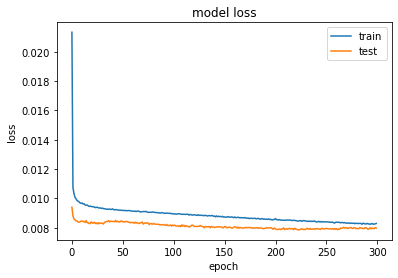

Test RMSE: 0.575
Test MSE: 0.331
Test MAE: 0.426


In [10]:
model = Sequential()
model.add(LSTM(200,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=300, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mse =mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)
mae =mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)